**Target:**
- Apply data augmentation Random Rotation (5 degree) and Learning rate scheduler with initial learning rate of 0.7 with step size of 5. 
- Apply dropout after each convolution block but with the reduced dropout value from 25% to 1%.

**Result:**
- Total Parameters: 7,624
- Train Accuracy: 99.31% (Epoch - 12)
- Test Accuracy: 99.49% (Epoch - 12)

**Analysis:**
- Train and Test Accuracy has increased drastically compared to that of Step-1, Step-2 and Step-3 but with a total number of parameters which is now 7,624 (<= 8,000).
- We have achieved accuracy >= 99.4% consistently with parameters <= 8,000.


**Receptive Field Calculation:**
```
Cin - Input Image Dimension
Rin - Initial Receptive field
Kernel - Size of kernel
Padding - Padding size 
Jin - Jump in
Jout - Jump output
RFnew - New Receptive field
Cout - Output Image dimension after convolution
Layers - Layer name
``` 


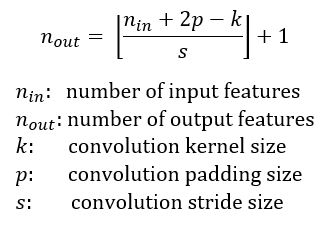


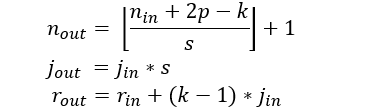


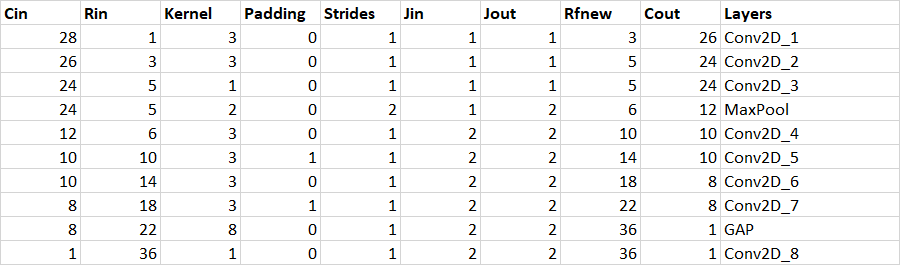

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       transforms.RandomRotation((-5.0, 5.0)) # 5 degree rotation
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 42

cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0003)
 - std: tensor(0.0800)
 - var: tensor(0.0064)
torch.Size([128, 1, 28, 28])
torch.Size([128])


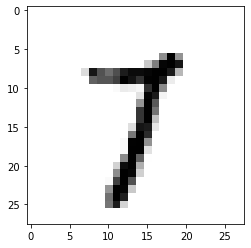

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


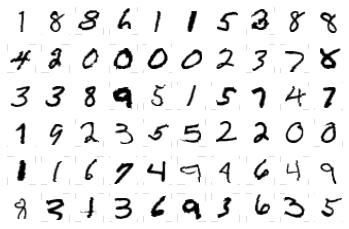

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,592
       BatchNorm2d-6           [-1, 24, 24, 24]              48
              ReLU-7           [-1, 24, 24, 24]               0
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             288
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]           1,080
      BatchNorm2d-12           [-1, 10, 10, 10]              20

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.7, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06821703165769577 Batch_id=468 Accuracy=92.21: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]



Test set: Average loss: 0.1121, Accuracy: 9646/10000 (96.46%)

EPOCH: 1


Loss=0.012850448489189148 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0585, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.10505787283182144 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:33<00:00, 13.95it/s]



Test set: Average loss: 0.0440, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.06393707543611526 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s]



Test set: Average loss: 0.0472, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.00970363337546587 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:34<00:00, 13.61it/s]



Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.01762702874839306 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 6


Loss=0.019288895651698112 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s]



Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.003288097446784377 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]



Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 8


Loss=0.006405061110854149 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]



Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


Loss=0.03874780610203743 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:32<00:00, 14.21it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.059441518038511276 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:33<00:00, 14.21it/s]



Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 11


Loss=0.03208620473742485 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:34<00:00, 13.49it/s]



Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.026280401274561882 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]



Test set: Average loss: 0.0177, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.002424957463517785 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]



Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.005281470715999603 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]



Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

